In [1]:
import torch
import torch.nn as nn

from torch.autograd import Variable
from torch import cat

from model import UNet
import torchvision
from torchvision import transforms
import numpy as np
import cv2

In [2]:
tensor_transform = transforms.ToTensor()

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=tensor_transform)

Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt

def display_rgb_image(img):
    plt.figure()
    plt.imshow(img)
    plt.show()
    
def display_lab_image(img):
    plt.figure()
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.imshow(img)
    plt.show()

In [4]:
rgb_images = []
numpy_lab_images = []
for image, label in testset:
    rgb_images.append(image)

for rgb_image in rgb_images:
    numpy_rgb_image = np.transpose(rgb_image.numpy(), (1, 2, 0))
    numpy_lab_image = cv2.cvtColor(numpy_rgb_image, cv2.COLOR_RGB2LAB)
    numpy_lab_images.append(numpy_lab_image)

In [5]:
lab_images = []
for numpy_lab_image in numpy_lab_images:
    numpy_lab_image[:, :, 0] *= 255 / 100
    numpy_lab_image[:, :, 1] += 128
    numpy_lab_image[:, :, 2] += 128
    numpy_lab_image /= 255
    torch_lab_image = torch.from_numpy(np.transpose(numpy_lab_image, (2, 0, 1)))
    lab_images.append(torch_lab_image)

In [6]:
class CieLABDataset(torch.utils.data.Dataset):
    """CieLab dataset."""    
    def __len__(self):
        return len(lab_images)

    def __getitem__(self, index):
        img = lab_images[index]
        return img

cielab_dataset = CieLABDataset()
cielab_loader = torch.utils.data.DataLoader(cielab_dataset, batch_size=1,
                  shuffle=False, num_workers=2)

In [7]:
generator = UNet(True)

In [8]:
generator.load_state_dict(torch.load('data/models/cifar10_train_generator'))
generator.eval()
generator.cuda()

RuntimeError: CUDA error: out of memory

In [157]:
def transform_display_image(i):
    i = i / 2
    mean = torch.Tensor([0.5])
    i = i + mean.expand_as(i)
    img = np.transpose(i.numpy(), (1, 2, 0))
    
    img = img * 255
    img[:, :, 2] -= 128.
    img[:, :, 1] -= 128.
    img[:, :, 0] *= 100./255.
    
    display_lab_image(img)

In [158]:
def visualize_result(fake_images, l_images, c_images):
    ground_truth = torch.cat([l_images, c_images], dim = 1).squeeze(0)
    gen_img = torch.cat([l_images, fake_images], dim = 1).squeeze(0)
    ground_truth = ground_truth.detach().cpu()
    gen_img = gen_img.detach().cpu()
    
    transform_display_image(ground_truth)
    transform_display_image(gen_img)

/home/as3ek/.local/lib/python3.6/site-packages/torch/tensor.py:287: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


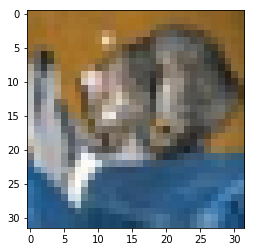

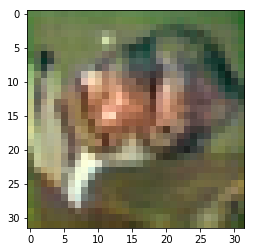

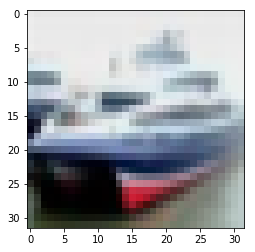

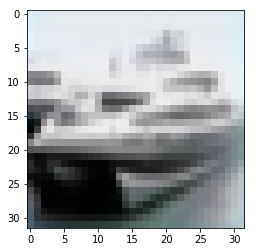

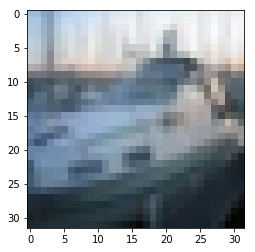

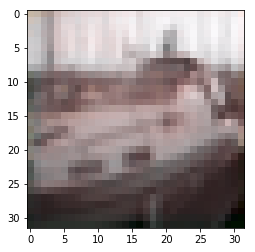

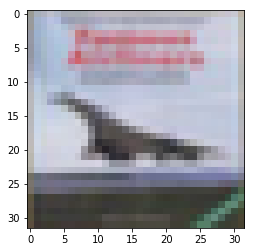

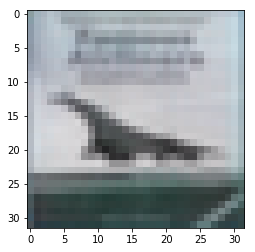

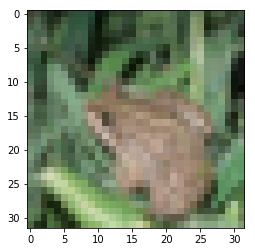

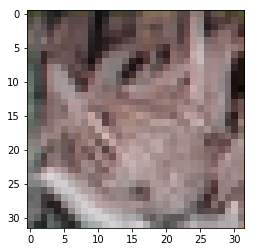

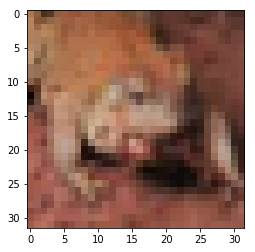

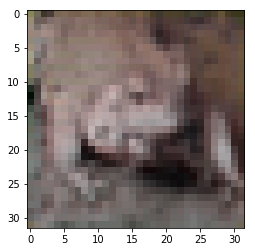

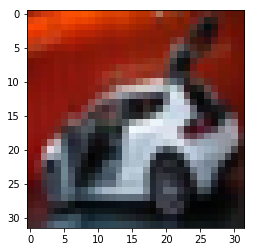

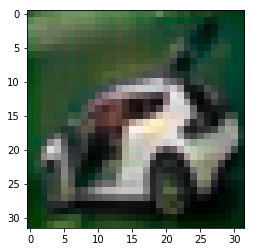

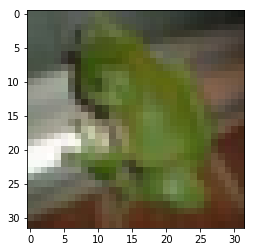

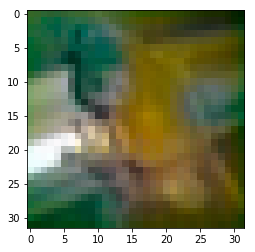

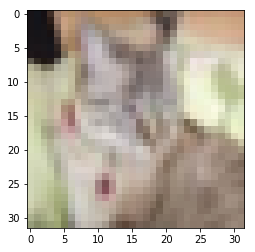

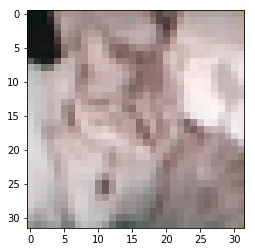

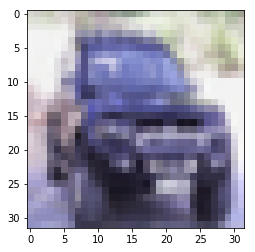

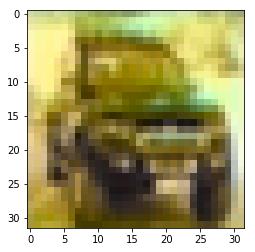

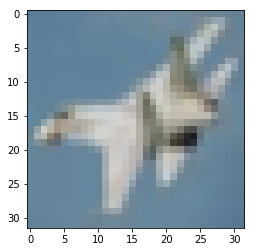

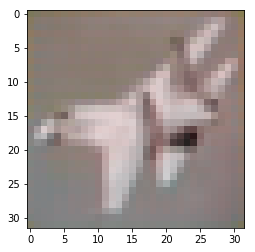

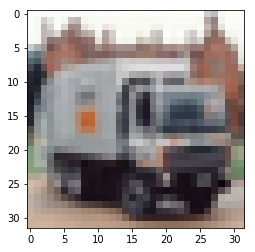

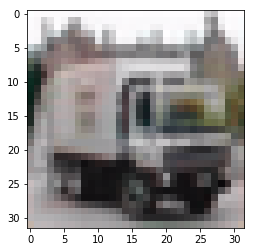

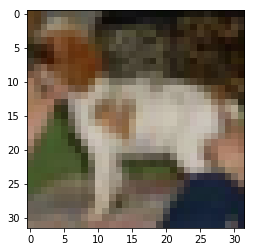

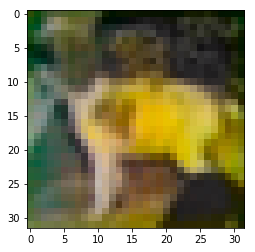

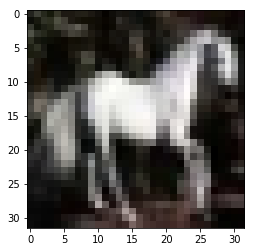

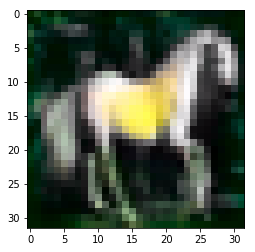

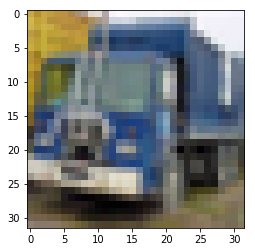

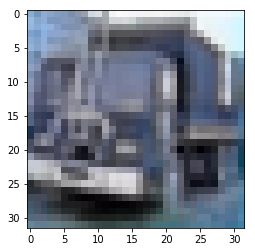

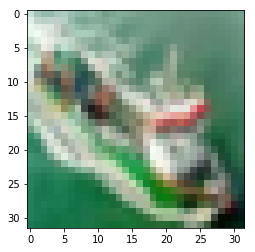

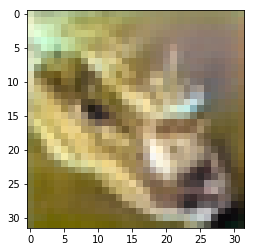

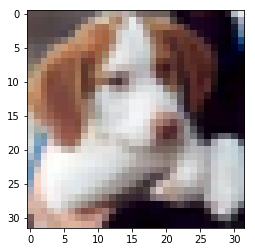

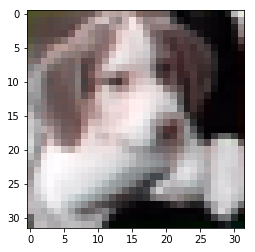

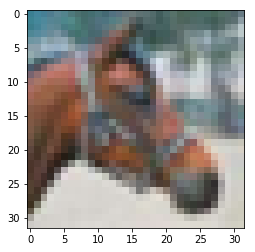

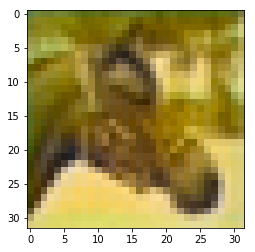

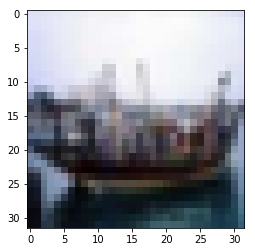

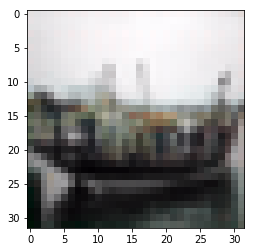

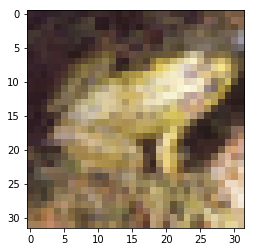

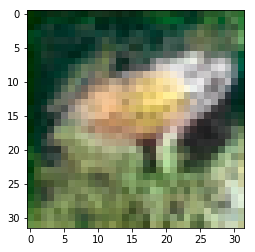

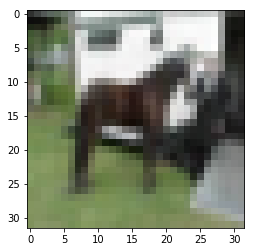

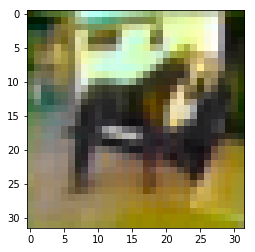

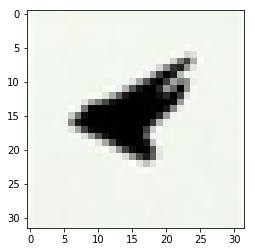

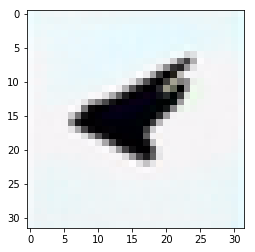

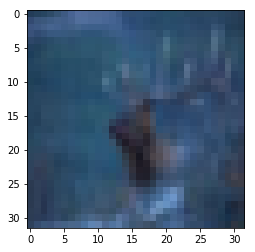

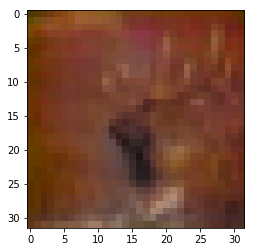

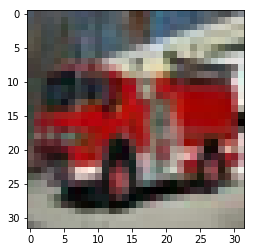

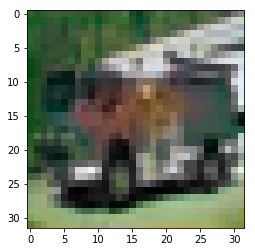

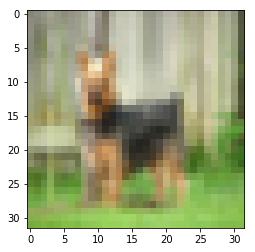

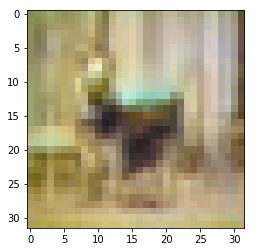

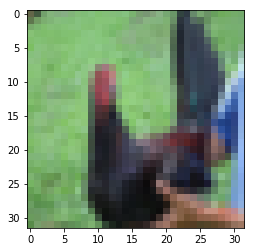

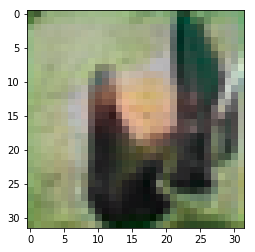

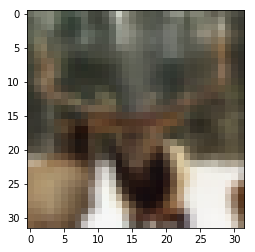

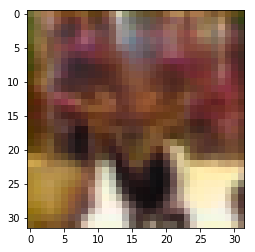

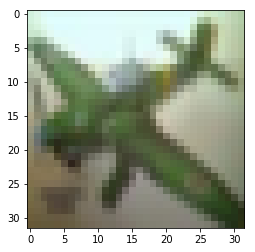

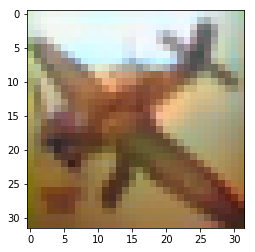

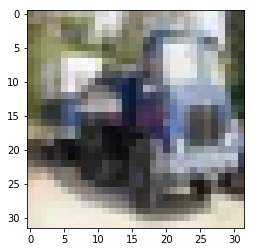

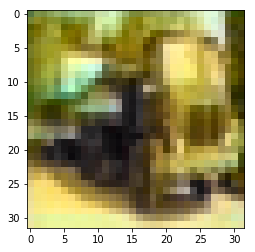

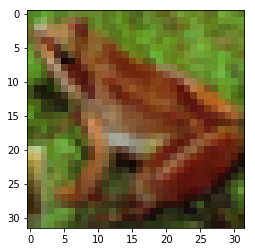

KeyboardInterrupt: 

In [160]:
l_criterion = nn.L1Loss()

"""
Evaluate the test dataset using L1 loss between the source and the generated image.
"""
running_loss = 0.0
num_steps = 0
for i, data in enumerate(cielab_loader):
    num_steps = num_steps + 1
    test_images = data
    # split the lab color space images into luminescence and chrominance channels.
    l_images = test_images[:, 0, :, :]
    c_images = test_images[:, 1:, :, :]
    # shift the source and target images into the range [-0.5, 0.5].
    mean = torch.Tensor([0.5])
    l_images = l_images - mean.expand_as(l_images)
    l_images = 2 * l_images

    c_images = c_images - mean.expand_as(c_images)
    c_images = 2 * c_images
    # allocate the images on the default gpu device.
    batch_size = l_images.shape[0]
    l_images = Variable(l_images.cuda())
    c_images = Variable(c_images.cuda())
    l_images = l_images.resize(batch_size, 1, 32, 32)
    c_images = c_images.resize(batch_size, 2, 32, 32)
    # fake images are generated by passing them through the generator.
    fake_images = generator(l_images)

    # Calculate the image distance loss pixelwise between the images.
    loss = l_criterion(fake_images, c_images)
    running_loss += loss
    visualize_result(fake_images, l_images, c_images)